# Artwork Classifier

## Introduction

In this project, we will classify artworks using the [artbench](https://github.com/liaopeiyuan/artbench) dataset. The dataset includes 60,000 images of artworks from 10 different artistic styles, including paintings, murals, and sculptures from the 14th to the 21st century. Each style has 5,000 training images and 1,000 test images.

We will predict the classes using PyTorch and leveraging *convolutional* and *transformer-based* models, namely the Resnet and Vision Transformers.

## Table of Contents

I. [Define parameters](#define-param)<br>
II. [Get Data](#get_data)<br>
III. [Data preparation](#data-prep)<br>
IV. [ViT_B16: Fine Tuning](#vit_b16_FT)<br>
V. [Resnet-50](#resnet-50)<br>

## <a class="anchor" id="define-param">I. Define parameters</a>

In [1]:
import torch
print(torch.__version__)
from torch import nn
from torch.utils.data import DataLoader

import torchvision
print(torchvision.__version__)
from torchvision import datasets,models,transforms
import torchinfo

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
from timeit import default_timer as timer
from pathlib import Path
import random,os
import wget,tarfile

import warnings
warnings.simplefilter("ignore", UserWarning)

/data/silama3/anaconda3/envs/art/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.12.1+cu113
0.13.1+cu113


In [2]:
Path('kaggle/working/results').mkdir(parents=True, exist_ok=True)
Path('kaggle/working/models').mkdir(parents=True, exist_ok=True)
Path('kaggle/working/gradio_demo/').mkdir(parents=True, exist_ok=True)

#########################################
# Define Parameters
#########################################
FLAGS = {}
# FLAGS['datadir'] = "./"
FLAGS['datadir'] = "kaggle/working/"
FLAGS['batch_size'] = 32
# FLAGS['num_workers'] = os.cpu_count()
FLAGS['num_workers'] = 0
FLAGS['num_epochs'] = 5
FLAGS['show_results_every_X_batch'] = 100
FLAGS['IMAGE_SIZE'] = 224

FLAGS

{'datadir': 'kaggle/working/',
 'batch_size': 32,
 'num_workers': 0,
 'num_epochs': 5,
 'show_results_every_X_batch': 100,
 'IMAGE_SIZE': 224}

In [3]:
PATH_results = Path(FLAGS['datadir'] + "results")
PATH_models = Path(FLAGS['datadir'] + "models")

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## <a class="anchor" id="get_data">II. Get data</a>

There are three versions of the dataset, each with a different resolution: 32x32, 256x256, and the original.

We will download the 256x256 ImageFolder with train-test split from [here](https://github.com/liaopeiyuan/artbench).

In [5]:
download = False # Set to True to start downloading

if download:
    # !wget https://artbench.eecs.berkeley.edu/files/artbench-10-imagefolder-split.tar
    
    import wget
    print("Download artbench-10-imagefolder-split.tar ...")
    wget.download(url="https://artbench.eecs.berkeley.edu/files/artbench-10-imagefolder-split.tar",
                  out = FLAGS['datadir'])
    
    # Uncompress the tar file
    import tarfile
    print("Uncompress the tar file...")
    data_path = Path(FLAGS['datadir'])
    file = tarfile.open(data_path / "artbench-10-imagefolder-split.tar")
    file.extractall(data_path)
    file.close()
    print("Tar file uncompressed!")

## <a class="anchor" id="data-prep">III. Data preparation</a>

In [6]:
data_path = Path(FLAGS['datadir'])
image_path = data_path / "artbench-10-imagefolder-split"

for dirpath, dirnames, filenames in os.walk(image_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 2 images in 'kaggle/working/artbench-10-imagefolder-split'.
There are 10 directories and 2 images in 'kaggle/working/artbench-10-imagefolder-split/test'.
There are 0 directories and 1000 images in 'kaggle/working/artbench-10-imagefolder-split/test/expressionism'.
There are 0 directories and 1000 images in 'kaggle/working/artbench-10-imagefolder-split/test/art_nouveau'.
There are 0 directories and 1000 images in 'kaggle/working/artbench-10-imagefolder-split/test/renaissance'.
There are 0 directories and 1000 images in 'kaggle/working/artbench-10-imagefolder-split/test/ukiyo_e'.
There are 0 directories and 1000 images in 'kaggle/working/artbench-10-imagefolder-split/test/realism'.
There are 0 directories and 1000 images in 'kaggle/working/artbench-10-imagefolder-split/test/romanticism'.
There are 0 directories and 1000 images in 'kaggle/working/artbench-10-imagefolder-split/test/surrealism'.
There are 0 directories and 1000 images in 'kaggle/working/artbench-1

### Visualize an image

Image class: surrealism
Image height: 256
Image width: 256


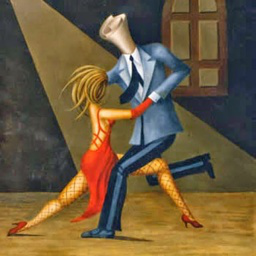

In [8]:
# 1. Get image paths 
image_path_list = list(image_path.glob("train/surrealism/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print Image class, heigt and width
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

### Transforming images

The `torchvision.transforms` module is used here to [transform and augment images](https://pytorch.org/vision/stable/transforms.html). A series of transforms is created using the `transforms.Compose` method.

The images are resized using `transforms.Resize()` and converted to tensor and scaled between 0 and 1 using `transforms.ToTensor()`.

To prevent overfitting, we will use [transforms.TrivialAugmentWide()](https://pytorch.org/vision/main/generated/torchvision.transforms.TrivialAugmentWide.html). This is an automatic augmentation method that transforms an image using a random transform from a given list with a random strength number between 0 and 31. We have found that a strength of 8 provides better accuracy and loss than higher magnitudes.

In [8]:
# from mixmatch_pytorch import MixMatchLoader, get_mixmatch_loss


# loader_mixmatch = MixMatchLoader(
#     loader_labeled,
#     dataset_unlabeled,
#     model,
#     output_transform=torch.sigmoid,
#     K=2,
#     T=0.5,
#     alpha=0.75
# )

# criterion = get_mixmatch_loss(
#     criterion_labeled=nn.BCEWithLogitsLoss(),
#     output_transform=torch.sigmoid,
#     K=2,
#     weight_unlabeled=100.,
#     criterion_unlabeled=nn.MSELoss()
# )

# for batch in loader_mixmatch:
#     logits = model(batch['features'].to(device))
#     loss = criterion(logits, batch['targets'])

In [10]:
data_transform = transforms.Compose([
transforms.Resize(size=(FLAGS['IMAGE_SIZE'], FLAGS['IMAGE_SIZE'])),
transforms.TrivialAugmentWide(num_magnitude_bins=8), # Data Augmentation
transforms.ToTensor()
])

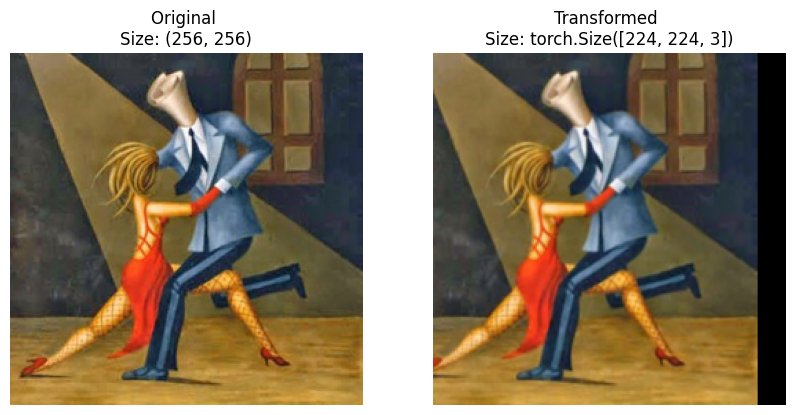

In [11]:
# # plot original vs. transformed image

# with Image.open(random_image_path) as f:
#   fig, ax = plt.subplots(1, 2,figsize=(10,7))
#   ax[0].imshow(f)
#   ax[0].set_title(f"Original \nSize: {f.size}")
#   ax[0].axis("off")

#   # Transform and plot image
#   transformed_image = data_transform(f).permute(1, 2, 0)
#   ax[1].imshow(transformed_image)
#   ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
#   ax[1].axis("off")

### Loading Image Data

To load image data and convert it into a Dataset, we will use [`ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder). The file path of the target image directory and our transform series are the main parameters of this method.

In [10]:
train_data = datasets.ImageFolder(root=image_path / "train", transform=data_transform)

test_data = datasets.ImageFolder(root=image_path / "test", transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 50000
    Root location: kaggle/working/artbench-10-imagefolder-split/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               TrivialAugmentWide(num_magnitude_bins=8, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 10000
    Root location: kaggle/working/artbench-10-imagefolder-split/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               TrivialAugmentWide(num_magnitude_bins=8, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )


In [11]:
# Get class names as a list
class_names = train_data.classes
class_names

['art_nouveau',
 'baroque',
 'expressionism',
 'impressionism',
 'post_impressionism',
 'realism',
 'renaissance',
 'romanticism',
 'surrealism',
 'ukiyo_e']

### Creating a subset of the Artbench dataset

We will create a subset of the Artbench dataset, say 20% of the data. This subset will be used to feed feature extractor models.

The full dataset will be used to fine tune the models

In [12]:
def split_dataset(dataset:torchvision.datasets, split_size:float=0.2, seed:int=42,device_=device):
    """Randomly splits a given dataset into two subsets based on split_size and seed.

    Args:
        dataset (torchvision.datasets): A PyTorch Dataset.
        split_size (float): the split size, defaults = 0.2.
        seed (int): Seed for random generator, defaults = 42.

    Returns:
        subset_1, subset_2 (tuple): the two subsets.
    """
    # Create split lengths 
    length_1 = int(len(dataset) * split_size)  # length of subset_1
    length_2 = len(dataset) - length_1 # length of subset_2

    # Print out info
    print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} ({int(split_size*100)}%), {length_2} ({int((1-split_size)*100)}%)")

    # Create splits with given random seed
    subset_1, subset_2 = torch.utils.data.random_split(dataset,
                                                       lengths=[length_1, length_2],
                                                       generator=torch.manual_seed(42)
                                                      )
    return subset_1, subset_2

In [15]:
# Create training 20% split of Artbench dataset
train_data_20_percent, _ = split_dataset(dataset=train_data, split_size=1)

# Create testing 20% split of Artbench dataset
test_data_20_percent, _ = split_dataset(dataset=test_data, split_size=1)

[INFO] Splitting dataset of length 50000 into splits of size: 50000 (100%), 0 (0%)
[INFO] Splitting dataset of length 10000 into splits of size: 10000 (100%), 0 (0%)


In [16]:
train_data_full = train_data
test_data_full = test_data

### Turn loaded images into `DataLoader`

The last step in preparing the data is to convert our Dataset into a DataLoader.

We can use [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) to convert our Dataset into a Python iterable, which we will use to iterate over batches. This method also supports automatic shuffling, and memory pinning.

In [18]:
# full dataset
train_DataLoader = DataLoader(dataset=train_data, batch_size=FLAGS['batch_size'],
                              num_workers=FLAGS['num_workers'], shuffle=True)
test_DataLoader = DataLoader(dataset=train_data, batch_size=FLAGS['batch_size'],
                             num_workers=FLAGS['num_workers'], shuffle=False)

# 100% of the data
train_DataLoader_100_percent = DataLoader(train_data_full,batch_size=FLAGS['batch_size'],
                                         num_workers=FLAGS['num_workers'], shuffle=True)
test_DataLoader_100_percent = DataLoader(test_data_full,batch_size=FLAGS['batch_size'],
                                        num_workers=FLAGS['num_workers'], shuffle=False)

print(f"Num batches using all data:  train: {len(train_DataLoader)} | test: {len(test_DataLoader)}")
print(f"Num batches 20% of the data: train: {len(train_DataLoader_100_percent)}  | test: {len(test_DataLoader_100_percent)}")


Num batches using all data:  train: 1563 | test: 1563
Num batches 20% of the data: train: 1563  | test: 313


### Data Preparation - Put it all together

Let's put it all together and create a function for data preparation:
1. Provide the path for the training directory and testing directory.
2. Turn them into PyTorch Datasets and then into PyTorch DataLoaders.

In [19]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=FLAGS['num_workers'],
    split_size: int=1 # if split_size<1, Create a subset of the dataset
):
  """Creates training and testing DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.
    split_size (float): the split size, default = 1 (no split)

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names) 
    where class_names is a list of the target classes.
  """
  # 1. Create datasets
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)
  print(f"Data size - Train: {len(train_data)} | Test: {len(test_data)}")

  # 2. Get class names
  class_names = train_data.classes

  # 3. Create a subset of the dataset
  if split_size<1:
    train_data, _ = split_dataset(dataset=train_data, split_size=split_size)
    test_data, _ =  split_dataset(dataset=test_data, split_size=split_size)
    print(f"Subset size - Train: {len(train_data)} | Test: {len(test_data)}")

  # 4. Create train and test DataLoaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      # num_workers=num_workers,
      # pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      # num_workers=num_workers,
      # pin_memory=True,
  )
  print(f"Number of batches of the dataloaders - Train: {len(train_dataloader)} | Test: {len(test_dataloader)}")

  return train_dataloader, test_dataloader, class_names

### Print a summary using torchinfo

In [20]:
def get_model_summary(model,input_size=(1,3,FLAGS['IMAGE_SIZE'],FLAGS['IMAGE_SIZE'])):
  """print and return the model summary using torchinfo.summary()"""
  model_summary = torchinfo.summary(model,
                                    input_size=input_size,
                                    col_names=["input_size","output_size","num_params","trainable"],
                                    col_width=15)
  print(model_summary)
  return model_summary

### Create DataLoaders using custom transforms (Resize + TrivialAugmentWide)

In [23]:
data_transform = transforms.Compose([
    transforms.Resize(size=(FLAGS['IMAGE_SIZE'], FLAGS['IMAGE_SIZE'])),
    transforms.TrivialAugmentWide(num_magnitude_bins=8), # Data Augmentation
    transforms.ToTensor()
])

train_DataLoader,test_DataLoader,class_names = create_dataloaders(train_dir=image_path / "train",
                                                                  test_dir=image_path / "test",
                                                                  transform=data_transform,
                                                                  batch_size=FLAGS['batch_size'],
                                                                  split_size=1)

Data size - Train: 50000 | Test: 10000
Number of batches of the dataloaders - Train: 1563 | Test: 313


### Create Accuracy function

In [24]:
def accuracy_fn(y_true, y_pred):
    """calculate accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels.
        y_pred (torch.Tensor): Predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred.
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

### Create train & test step functions

we will create three functions:
1. `train_step()` - trains the model on the train_DataLoader.
2. `test_step()` - evaluates the model on the test_DataLoader.
3. `train_and_evaluate()` - Creates a train and test loop using train_step and test_step. It trains, evaluates the model and tracks the results.


#### Create a train step function

This function traines the model for one epoch using all batches in the train_DataLoader. Once the epoch is complete, the train_loss and train_accuracy are returned.

In [25]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    """Train the model on the dataloader"""
    
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
        # 1. Send data to target device
        X, y = X.to(device), y.to(device)

        # 2. Forward pass
        pred_logits = model(X)
        pred_labels = torch.argmax(torch.softmax(pred_logits, dim=1), dim=1)

        # 3. Calculate and accumulate loss
        loss = loss_fn(pred_logits, y)
        train_loss += loss.item()

        # 4. Calculate and accumulate accuracy 
        acc = accuracy_fn(y,pred_labels)
        train_acc += acc

        # 5. Gradient Descent
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 6. print train loss and accuracy per batch
        if batch % FLAGS['show_results_every_X_batch'] == 0:
          print(f"batch: {batch} | train_loss: {loss.item()} | train_acc: {acc}")

    # 7. Get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

#### Create a test loop function

In [26]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    """Evaluate the model on the dataloader"""
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # 1. Send data to target device
            X, y = X.to(device), y.to(device)

            # 2. Forward pass
            test_pred_logits = model(X)
            test_pred_labels = test_pred_logits.argmax(dim=1)

            # 3. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # 4. Calculate and accumulate accuracy
            test_acc += accuracy_fn(y,test_pred_labels)

    # 5. Get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

#### Combine train and test loop functions

Let's combine the train and test loop function in one function: train_and_evaluate.

We will use CrossEntropyLoss as the loss function and Adam as the optimizer. The learning rate for the Adam optimizer is set to 0.001 by default.

In [27]:
from tqdm.auto import tqdm

def train_and_evaluate(model: torch.nn.Module,
                       train_dataloader: torch.utils.data.DataLoader,
                       test_dataloader: torch.utils.data.DataLoader,
                       epochs: int = 5,
                       learning_rate = 0.001):
    """Train the model for a number of epochs, evaluate the model and track the results."""
    
    # Create empty results dictionary
    results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
      }

    # Set random seeds
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

    # Setup loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

    # Start the timer
    from timeit import default_timer as timer
    start_time = timer()

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        print(f"\nepoch: {epoch}\n--------------------------")
        train_loss, train_acc = train_step(model=model,
                                            dataloader=train_dataloader,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # Print results per epoch
        print(
            f"Epoch: {epoch} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )        

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    end_time = timer()
    print(f"Total training time: {end_time-start_time:.3f} seconds")

    return results

### Save the results to CSV

In [28]:
def save_results_to_CSV(model_results,model_name,split_size,results_save_path):
  model_results_pd = pd.DataFrame(model_results)
  model_results_pd['model_name'] = model_name
  model_results_pd['data'] = split_size
  print(f"Saving results to: {results_save_path}")
  model_results_pd.to_csv(results_save_path,index=False)

### Plot loss curves

In [29]:
def plot_loss_curves(results,graph_name="fig",save_graph=False,
                     PATH_results=PATH_results,suptitle=""):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g. {"train_loss": [...], "train_acc": [...],...}
        graph_name (str): the name of the graph
        save_graph (boolean): if True, the graph will be saved
        PATH_results: the path where the graph will be stored
        suptitle (str): add a suptitle, default None
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    if suptitle!="":
        plt.suptitle(suptitle, fontsize=18)
    
    # Save the figure
    if save_graph:
        graph_name = graph_name+".jpg"
        plt.savefig(PATH_results / graph_name)

The TinyVGG model performed poorly with an accuracy of 31%, but this is better than guessing (if our model were to guess, the accuracy would be 10%).

We could try to train the model for longer and see what happens.

### Save the model

We will save model's `state_dict()` using `torch.save()`.

In [30]:
def save_model(model,MODEL_SAVE_PATH):
  """Save the model state dict: only saves the learned parameters"""

  print(f"Saving model to: {MODEL_SAVE_PATH}")
  torch.save(obj=model.state_dict(),
             f=MODEL_SAVE_PATH)

### Make predictions and calculate average prediction time

Let's create a function called `pred_and_timing()` to iterate over test images and find the average prediction time.

In [31]:
# Get all test data paths
test_dir = image_path / "test"
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Get 200 random images 
random_image_paths = random.sample(test_data_paths,200)
print(f"[INFO] Random selection of 200 images from {test_dir}")

[INFO] Random selection of 200 images from kaggle/working/artbench-10-imagefolder-split/test


In [27]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

def pred_and_timing(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
    print("\nMake predictions and calculate average prediction time...")

    pred_list = [] # list to store prediction dictionaires

    for path in tqdm(paths):

        pred_dict = {} # dict to store prediction information (path, class_name, pred_prob, pred_class and time_for_pred) 

        # Set path and class_name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        start_time = timer() # 5. Start the prediction timer

        # Open image path
        img = Image.open(path)

        # Transform the image and add batch dimension
        transformed_image = transform(img).unsqueeze(0).to(device)

        # Prepare model for inference
        model.to(device)
        model.eval()

        # Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # prediction logits
            pred_prob = torch.softmax(pred_logit, dim=1) # prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # prediction labels
            pred_class = class_names[pred_label.cpu()] 

            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            # Calculate prediction time
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # Was the prediction right?
        pred_dict["correct"] = class_name == pred_class

        # Add the dict to the list of preds 
        pred_list.append(pred_dict)

        # Convert to dataframe
        pred_df = pd.DataFrame(pred_list)

        # Calculate average prediction time
        avg_prediction_time = round(pred_df.time_for_pred.mean(), 4)

    return pred_list,pred_df,avg_prediction_time

> As we will be deploying our application on HuggingFace Spaces and using free CPUs, we will check the average prediction time of our model using the CPU device.

### Collect model stats

The stats include:
1. model size in Bytes
2. number of parameters
3. test loss and accuracy
4. average prediction time

In [32]:
def get_model_stats(model_name,MODEL_SAVE_PATH,model_summary,model_results,avg_prediction_time):
  """return model size in megabytes, number of parameters, test loss/accuray and avg_prediction_time"""

  model_size = np.round(MODEL_SAVE_PATH.stat().st_size / (1024*1024),1)
  num_parameters = model_summary.total_params
  # Create model statistics dictionary
  model_stats = {"model_name":model_name,
                 "test_loss": np.round(model_results["test_loss"][-1],3),
                 "test_acc": np.round(model_results["test_acc"][-1],3),
                 "number_of_parameters": num_parameters,
                 "model_size (MB)": model_size,
                 "avg_prediction_time":avg_prediction_time}
  return model_stats

## <a class="anchor" id="vit_b16_FE">Transformer model - ViT_B16: Feature Extraction</a>

We will create a ViT feature extractor model
 leveraging [`torchvision.models.vit_b_16()`](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16)

1. Freeze all layers of the model
2. Change the classifier head (set out_features to 10 classes)

In [33]:
# Check out ViT heads layer
vit = torchvision.models.vit_b_16()
vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate=none)
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_att

### Build the ViT model

In [34]:
def create_vit_model(num_classes:int=10,
                     seed:int=42,
                     is_TrivialAugmentWide = True,
                     freeze_layers=True
                     ):
    """Creates a ViT_B16 feature extractor model and transforms.

    Args:
        num_classes (int): number of target classes, default = 10.
        seed (int, optional): random seed value for output layer, default = 42.
        is_TrivialAugmentWide (boolean): Artificially increase the diversity of a training dataset with data augmentation, default = True.
        freeze_layers (boolean): freeze all layers in model, default = True.                                     

    Returns:
        vit_b16_model (torch.nn.Module): ViT_B16 feature extractor model.
        vit_b16_transforms (torchvision.transforms): ViT_B16 image transforms.
    """
    # Create ViT_B_16 pretrained weights and transforms
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    vit_b16_transforms = weights.transforms()
    # add data augmentation
    if is_TrivialAugmentWide:
      vit_b16_transforms = torchvision.transforms.Compose([
          torchvision.transforms.TrivialAugmentWide(num_magnitude_bins=8),
          vit_b16_transforms,
      ])
    # create the VIT_B16 model
    vit_b16_model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in the model
    if freeze_layers:
        for param in vit_b16_model.parameters():
            param.requires_grad = False

    # Change classifier head to reflect target number of classes
    torch.manual_seed(seed)
    vit_b16_model.heads = nn.Sequential(nn.Linear(in_features=768,
                                                  out_features=num_classes)) 

    return vit_b16_model, vit_b16_transforms

In [35]:
# Create ViT feature extractor model and transforms
model_ViT, vit_transforms = create_vit_model(num_classes=len(class_names),
                                             seed=42,
                                             is_TrivialAugmentWide=True)

# Print ViT feature extractor model summary
summary_ViT = get_model_summary(model_ViT)

Layer (type:depth-idx)                        Input Shape     Output Shape    Param #         Trainable
VisionTransformer                             [1, 3, 224, 224] [1, 10]         768             Partial
├─Conv2d: 1-1                                 [1, 3, 224, 224] [1, 768, 14, 14] (590,592)       False
├─Encoder: 1-2                                [1, 197, 768]   [1, 197, 768]   151,296         False
│    └─Dropout: 2-1                           [1, 197, 768]   [1, 197, 768]   --              --
│    └─Sequential: 2-2                        [1, 197, 768]   [1, 197, 768]   --              False
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]   [1, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock: 3-2                 [1, 197, 768]   [1, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock: 3-3                 [1, 197, 768]   [1, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock: 3-4                 [1, 197, 768]   [1, 197, 768]   (7,087,872)     

### Create dataloaders using ViT transforms

In [36]:
# Train and test the ViT feature extractor on 20% of the data
train_DataLoader,test_DataLoader,class_names = create_dataloaders(train_dir=image_path / "train",
                                                                  test_dir=image_path / "test",
                                                                  transform=vit_transforms,
                                                                  batch_size=FLAGS['batch_size'],
                                                                  split_size=1)

Data size - Train: 50000 | Test: 10000
Number of batches of the dataloaders - Train: 1563 | Test: 313


### Train, evaluate and save results of the ViT_B16 feature extractor

In [37]:
# 1. train and evaluate the model
results_ViT_100percent = train_and_evaluate(model=model_ViT,
                                           train_dataloader=train_DataLoader,
                                           test_dataloader=test_DataLoader,
                                           epochs=5)

  0%|                                                                                                                                                                                 | 0/5 [00:00<?, ?it/s]


epoch: 0
--------------------------
batch: 0 | train_loss: 2.404925584793091 | train_acc: 0.0
batch: 100 | train_loss: 1.9437439441680908 | train_acc: 37.5
batch: 200 | train_loss: 1.4524770975112915 | train_acc: 46.875
batch: 300 | train_loss: 1.3844200372695923 | train_acc: 46.875
batch: 400 | train_loss: 1.3687752485275269 | train_acc: 56.25
batch: 500 | train_loss: 1.366724967956543 | train_acc: 46.875
batch: 600 | train_loss: 1.1423505544662476 | train_acc: 65.625
batch: 700 | train_loss: 1.1210052967071533 | train_acc: 59.375
batch: 800 | train_loss: 1.3523648977279663 | train_acc: 53.125
batch: 900 | train_loss: 1.1683765649795532 | train_acc: 68.75
batch: 1000 | train_loss: 1.412827730178833 | train_acc: 43.75
batch: 1100 | train_loss: 1.335054636001587 | train_acc: 50.0
batch: 1200 | train_loss: 1.3421059846878052 | train_acc: 40.625
batch: 1300 | train_loss: 1.0439505577087402 | train_acc: 56.25
batch: 1400 | train_loss: 1.0390914678573608 | train_acc: 68.75
batch: 1500 | tr

 20%|█████████████████████████████████▌                                                                                                                                      | 1/5 [06:02<24:09, 362.36s/it]

Epoch: 0 | train_loss: 1.4279 | train_acc: 48.2406 | test_loss: 1.3280 | test_acc: 51.8770

epoch: 1
--------------------------
batch: 0 | train_loss: 1.575683355331421 | train_acc: 37.5
batch: 100 | train_loss: 1.429988980293274 | train_acc: 59.375
batch: 200 | train_loss: 1.2959136962890625 | train_acc: 56.25
batch: 300 | train_loss: 1.1407729387283325 | train_acc: 53.125
batch: 400 | train_loss: 1.6296801567077637 | train_acc: 37.5
batch: 500 | train_loss: 1.2516473531723022 | train_acc: 53.125
batch: 600 | train_loss: 1.3235234022140503 | train_acc: 50.0
batch: 700 | train_loss: 0.9836633205413818 | train_acc: 71.875
batch: 800 | train_loss: 1.1761013269424438 | train_acc: 53.125
batch: 900 | train_loss: 1.2301299571990967 | train_acc: 53.125
batch: 1000 | train_loss: 1.0190460681915283 | train_acc: 62.5
batch: 1100 | train_loss: 1.1914101839065552 | train_acc: 46.875
batch: 1200 | train_loss: 1.6450722217559814 | train_acc: 37.5
batch: 1300 | train_loss: 1.4409679174423218 | train

 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 2/5 [11:59<17:58, 359.34s/it]

Epoch: 1 | train_loss: 1.2837 | train_acc: 53.2969 | test_loss: 1.3000 | test_acc: 52.9752

epoch: 2
--------------------------
batch: 0 | train_loss: 1.2619690895080566 | train_acc: 56.25
batch: 100 | train_loss: 1.2000871896743774 | train_acc: 59.375
batch: 200 | train_loss: 1.1604268550872803 | train_acc: 65.625
batch: 300 | train_loss: 1.0087666511535645 | train_acc: 68.75
batch: 400 | train_loss: 1.1262317895889282 | train_acc: 65.625
batch: 500 | train_loss: 1.3821526765823364 | train_acc: 50.0
batch: 600 | train_loss: 1.3577581644058228 | train_acc: 43.75
batch: 700 | train_loss: 1.0704712867736816 | train_acc: 62.5
batch: 800 | train_loss: 1.118192195892334 | train_acc: 62.5
batch: 900 | train_loss: 1.0701254606246948 | train_acc: 62.5
batch: 1000 | train_loss: 0.9444406628608704 | train_acc: 65.625
batch: 1100 | train_loss: 0.9937536716461182 | train_acc: 65.625
batch: 1200 | train_loss: 1.2593704462051392 | train_acc: 50.0
batch: 1300 | train_loss: 1.2061978578567505 | train_

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 3/5 [17:57<11:57, 358.83s/it]

Epoch: 2 | train_loss: 1.2603 | train_acc: 54.3326 | test_loss: 1.3042 | test_acc: 52.3562

epoch: 3
--------------------------
batch: 0 | train_loss: 1.2007302045822144 | train_acc: 56.25
batch: 100 | train_loss: 1.1405060291290283 | train_acc: 62.5
batch: 200 | train_loss: 1.1735496520996094 | train_acc: 56.25
batch: 300 | train_loss: 1.528644323348999 | train_acc: 43.75
batch: 400 | train_loss: 1.4886161088943481 | train_acc: 37.5
batch: 500 | train_loss: 1.4318591356277466 | train_acc: 37.5
batch: 600 | train_loss: 0.890108048915863 | train_acc: 75.0
batch: 700 | train_loss: 1.5850380659103394 | train_acc: 31.25
batch: 800 | train_loss: 0.9324730038642883 | train_acc: 68.75
batch: 900 | train_loss: 1.3980311155319214 | train_acc: 50.0
batch: 1000 | train_loss: 1.119335651397705 | train_acc: 62.5
batch: 1100 | train_loss: 1.3006445169448853 | train_acc: 50.0
batch: 1200 | train_loss: 1.241164207458496 | train_acc: 50.0
batch: 1300 | train_loss: 1.305869221687317 | train_acc: 59.375


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 4/5 [24:00<06:00, 360.36s/it]

Epoch: 3 | train_loss: 1.2486 | train_acc: 54.3706 | test_loss: 1.2940 | test_acc: 53.2548

epoch: 4
--------------------------
batch: 0 | train_loss: 0.9781996607780457 | train_acc: 62.5
batch: 100 | train_loss: 0.8281729221343994 | train_acc: 71.875
batch: 200 | train_loss: 0.7578628659248352 | train_acc: 68.75
batch: 300 | train_loss: 1.0673727989196777 | train_acc: 56.25
batch: 400 | train_loss: 1.055467128753662 | train_acc: 53.125
batch: 500 | train_loss: 0.9115921258926392 | train_acc: 56.25
batch: 600 | train_loss: 1.6658819913864136 | train_acc: 31.25
batch: 700 | train_loss: 1.405900001525879 | train_acc: 43.75
batch: 800 | train_loss: 0.8948802947998047 | train_acc: 68.75
batch: 900 | train_loss: 1.1113094091415405 | train_acc: 56.25
batch: 1000 | train_loss: 1.194635272026062 | train_acc: 62.5
batch: 1100 | train_loss: 1.1306853294372559 | train_acc: 62.5
batch: 1200 | train_loss: 1.4556688070297241 | train_acc: 46.875
batch: 1300 | train_loss: 1.3809987306594849 | train_ac

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [30:00<00:00, 360.18s/it]

Epoch: 4 | train_loss: 1.2428 | train_acc: 54.8265 | test_loss: 1.3034 | test_acc: 52.7955
Total training time: 1800.899 seconds


Saving results to: kaggle/working/results/results_ViT_B16_100percent.csv
Saving model to: kaggle/working/models/ViT_B16_100percent.pth


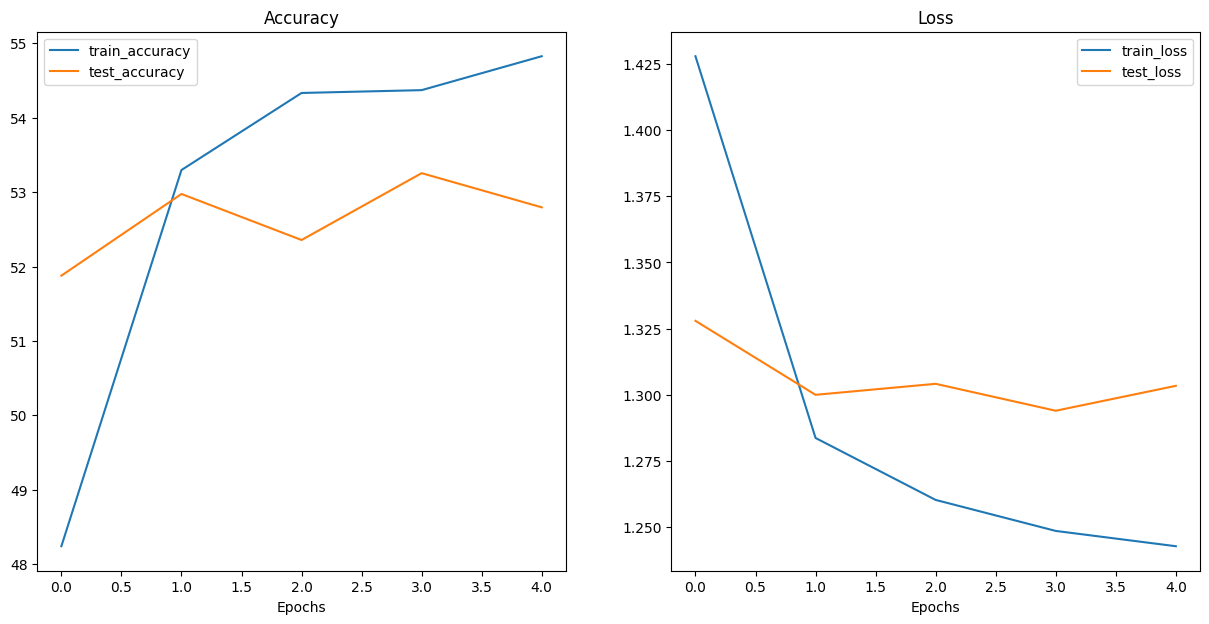

In [42]:
# 2. Plot loss curves
plot_loss_curves(results_ViT_100percent,
                 graph_name="fig_ViT_100percent",save_graph=True)

# 3. Save results
save_results_to_CSV(model_results=results_ViT_100percent,
                    model_name = "ViT_B16",
                    split_size = 1,
                    results_save_path = PATH_results / "results_ViT_B16_100percent.csv")

# 4. Save the model
save_model(model = model_ViT,
           MODEL_SAVE_PATH = PATH_models / "ViT_B16_100percent.pth"
           )


In [44]:

# 5. Make predictions and calculate avg prediction time
ViT_test_pred_dicts,ViT_test_pred_df,ViT_avg_prediction_time =\
pred_and_timing(paths=random_image_paths,
                model=model_ViT,
                transform=vit_transforms,
                class_names=class_names,
                device="cpu") # make predictions on CPU

print("ViT_avg_prediction_time:",ViT_avg_prediction_time)

# 6. Collect model stats
stats_ViT_20percent = get_model_stats(model_name = "ViT_B16",
                                      MODEL_SAVE_PATH = PATH_models / "ViT_B16_100percent.pth",
                                      model_summary= summary_ViT,
                                      model_results = results_ViT_100percent,
                                      avg_prediction_time= ViT_avg_prediction_time
                                      )
# 7. Save the stats to csv
pd.DataFrame([stats_ViT_20percent]).to_csv(PATH_results / "stats_ViT_100percent.csv",index=False)
print("\nstats_ViT_100percent:")
stats_ViT_20percent


Make predictions and calculate average prediction time...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 24.72it/s]

ViT_avg_prediction_time: 0.039

stats_ViT_100percent:


{'model_name': 'ViT_B16',
 'test_loss': 1.303,
 'test_acc': 52.796,
 'number_of_parameters': 85806346,
 'model_size (MB)': 327.4,
 'avg_prediction_time': 0.039}

The ViT_B16 feature extractor achieved over **49%** accuracy on test dataset. 

## <a class="anchor" id="vit_b16_FT">IV. ViT_B16: Fine Tuning</a>

1. Create a new instance of ViT_B16 with all its layers trainable.
2. Load the state_dict of our saved feature extractor model. This will update the new instance of our model with trained weights
3. Train the model for an additional 5 epochs on 50% of the dataset (to make the training time faster).

In [45]:
# 1. Create a new instance of ViT model and ViT transforms
model_ViT, vit_transforms = create_vit_model(num_classes=len(class_names),
                                             seed=42,
                                             is_TrivialAugmentWide=True,
                                             freeze_layers=False)
summary_ViT = get_model_summary(model_ViT)

Layer (type:depth-idx)                        Input Shape     Output Shape    Param #         Trainable
VisionTransformer                             [1, 3, 224, 224] [1, 10]         768             True
├─Conv2d: 1-1                                 [1, 3, 224, 224] [1, 768, 14, 14] 590,592         True
├─Encoder: 1-2                                [1, 197, 768]   [1, 197, 768]   151,296         True
│    └─Dropout: 2-1                           [1, 197, 768]   [1, 197, 768]   --              --
│    └─Sequential: 2-2                        [1, 197, 768]   [1, 197, 768]   --              True
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]   [1, 197, 768]   7,087,872       True
│    │    └─EncoderBlock: 3-2                 [1, 197, 768]   [1, 197, 768]   7,087,872       True
│    │    └─EncoderBlock: 3-3                 [1, 197, 768]   [1, 197, 768]   7,087,872       True
│    │    └─EncoderBlock: 3-4                 [1, 197, 768]   [1, 197, 768]   7,087,872       True
│   

In [46]:
# 2. Load the state_dict of our saved ViT feature extractor 
MODEL_SAVE_PATH = PATH_models / "ViT_B16_100percent.pth"
model_ViT.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [47]:
# 3. Create dataloaders using ViT_B16 transforms and 100% of the data
train_DataLoader,test_DataLoader,class_names = create_dataloaders(train_dir=image_path / "train",
                                                                  test_dir=image_path / "test",
                                                                  transform=vit_transforms,
                                                                  batch_size=FLAGS['batch_size'],
                                                                  split_size=1)

Data size - Train: 50000 | Test: 10000
Number of batches of the dataloaders - Train: 1563 | Test: 313


In [48]:
# 4. train and evaluate the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)
results_ViT_FT = train_and_evaluate(model=model_ViT,
                                    train_dataloader=train_DataLoader,
                                    test_dataloader=test_DataLoader,
                                    epochs=5,
                                    learning_rate=0.0001)

# 5. Save results
save_results_to_CSV(model_results=results_ViT_FT,
                    model_name = "ViT_B16",
                    split_size = 1,
                    results_save_path = PATH_results / "results_ViT_B16_FT.csv")

# 6. Save the model
save_model(model = model_ViT,
           MODEL_SAVE_PATH = PATH_models / "ViT_B16_FT.pth"
           )

# 7. Make predictions and calculate avg prediction time 
ViT_test_pred_dicts,ViT_test_pred_df,ViT_avg_prediction_time =\
pred_and_timing(paths=random_image_paths,
                model=model_ViT,
                transform=vit_transforms,
                class_names=class_names,
                device="cpu") # make predictions on CPU

print("ViT_avg_prediction_time:",ViT_avg_prediction_time)

# 8. Collect model stats
stats_ViT_FT = get_model_stats(model_name = "ViT_B16",
                               MODEL_SAVE_PATH = PATH_models / "ViT_B16_FT.pth",
                               model_summary= summary_ViT,
                               model_results = results_ViT_FT,
                               avg_prediction_time= ViT_avg_prediction_time
                              )
# 9. Save the stats to csv
pd.DataFrame([stats_ViT_FT]).to_csv(PATH_results / "stats_ViT_FT.csv",index=False)
print("\nstats_ViT_FT:")
stats_ViT_FT

  0%|                                                                                                                                                                                 | 0/5 [00:00<?, ?it/s]


epoch: 0
--------------------------
batch: 0 | train_loss: 0.983346700668335 | train_acc: 65.625
batch: 100 | train_loss: 1.5477039813995361 | train_acc: 50.0
batch: 200 | train_loss: 1.1950050592422485 | train_acc: 59.375
batch: 300 | train_loss: 1.3609884977340698 | train_acc: 46.875
batch: 400 | train_loss: 1.296349287033081 | train_acc: 43.75
batch: 500 | train_loss: 1.1580640077590942 | train_acc: 50.0
batch: 600 | train_loss: 0.9687901735305786 | train_acc: 56.25
batch: 700 | train_loss: 0.8450694680213928 | train_acc: 78.125
batch: 800 | train_loss: 0.9181113243103027 | train_acc: 62.5
batch: 900 | train_loss: 1.080979585647583 | train_acc: 56.25
batch: 1000 | train_loss: 1.6402429342269897 | train_acc: 43.75
batch: 1100 | train_loss: 1.0382851362228394 | train_acc: 62.5
batch: 1200 | train_loss: 1.0420496463775635 | train_acc: 59.375
batch: 1300 | train_loss: 0.8224526643753052 | train_acc: 68.75
batch: 1400 | train_loss: 0.9472055435180664 | train_acc: 68.75
batch: 1500 | tra

 20%|█████████████████████████████████▌                                                                                                                                      | 1/5 [11:41<46:46, 701.63s/it]

Epoch: 0 | train_loss: 1.2380 | train_acc: 54.2426 | test_loss: 1.1651 | test_acc: 56.9589

epoch: 1
--------------------------
batch: 0 | train_loss: 1.248093843460083 | train_acc: 50.0
batch: 100 | train_loss: 1.3727972507476807 | train_acc: 56.25
batch: 200 | train_loss: 1.1806994676589966 | train_acc: 65.625
batch: 300 | train_loss: 1.1376330852508545 | train_acc: 50.0
batch: 400 | train_loss: 1.2587542533874512 | train_acc: 46.875
batch: 500 | train_loss: 1.0414974689483643 | train_acc: 56.25
batch: 600 | train_loss: 1.0290974378585815 | train_acc: 62.5
batch: 700 | train_loss: 0.8682460784912109 | train_acc: 71.875
batch: 800 | train_loss: 0.9518831968307495 | train_acc: 59.375
batch: 900 | train_loss: 1.3532737493515015 | train_acc: 40.625
batch: 1000 | train_loss: 1.0185070037841797 | train_acc: 65.625
batch: 1100 | train_loss: 1.18006432056427 | train_acc: 46.875
batch: 1200 | train_loss: 1.020058274269104 | train_acc: 53.125
batch: 1300 | train_loss: 1.3193352222442627 | trai

 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 2/5 [23:25<35:08, 702.78s/it]

Epoch: 1 | train_loss: 1.0496 | train_acc: 60.9785 | test_loss: 1.1430 | test_acc: 57.7776

epoch: 2
--------------------------
batch: 0 | train_loss: 0.7329494953155518 | train_acc: 71.875
batch: 100 | train_loss: 0.9061328768730164 | train_acc: 71.875
batch: 200 | train_loss: 1.0486671924591064 | train_acc: 65.625
batch: 300 | train_loss: 0.69168621301651 | train_acc: 81.25
batch: 400 | train_loss: 0.9865267276763916 | train_acc: 65.625
batch: 500 | train_loss: 0.8637447357177734 | train_acc: 68.75
batch: 600 | train_loss: 1.1554362773895264 | train_acc: 53.125
batch: 700 | train_loss: 0.9240992069244385 | train_acc: 59.375
batch: 800 | train_loss: 0.7660124897956848 | train_acc: 71.875
batch: 900 | train_loss: 0.9392485022544861 | train_acc: 71.875
batch: 1000 | train_loss: 0.8533391356468201 | train_acc: 68.75
batch: 1100 | train_loss: 0.9327123761177063 | train_acc: 71.875
batch: 1200 | train_loss: 0.7939687967300415 | train_acc: 68.75
batch: 1300 | train_loss: 0.9603030681610107 

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 3/5 [35:11<23:28, 704.39s/it]

Epoch: 2 | train_loss: 0.9469 | train_acc: 64.7673 | test_loss: 1.1227 | test_acc: 58.8858

epoch: 3
--------------------------
batch: 0 | train_loss: 0.8763257265090942 | train_acc: 71.875
batch: 100 | train_loss: 0.9034304022789001 | train_acc: 71.875
batch: 200 | train_loss: 0.870498538017273 | train_acc: 71.875
batch: 300 | train_loss: 0.8630273938179016 | train_acc: 68.75
batch: 400 | train_loss: 0.6943511962890625 | train_acc: 75.0
batch: 500 | train_loss: 1.0074095726013184 | train_acc: 62.5
batch: 600 | train_loss: 0.7025052309036255 | train_acc: 71.875
batch: 700 | train_loss: 0.9427797198295593 | train_acc: 53.125
batch: 800 | train_loss: 0.526360034942627 | train_acc: 81.25
batch: 900 | train_loss: 0.9459928870201111 | train_acc: 65.625
batch: 1000 | train_loss: 0.6779686212539673 | train_acc: 75.0
batch: 1100 | train_loss: 0.6233851909637451 | train_acc: 78.125
batch: 1200 | train_loss: 0.6124780178070068 | train_acc: 81.25
batch: 1300 | train_loss: 1.1011089086532593 | tra

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 4/5 [46:53<11:43, 703.64s/it]

Epoch: 3 | train_loss: 0.8427 | train_acc: 68.7740 | test_loss: 1.1882 | test_acc: 57.6877

epoch: 4
--------------------------
batch: 0 | train_loss: 0.8593881130218506 | train_acc: 75.0
batch: 100 | train_loss: 0.5646759271621704 | train_acc: 78.125
batch: 200 | train_loss: 0.3030072748661041 | train_acc: 90.625
batch: 300 | train_loss: 0.629587709903717 | train_acc: 78.125
batch: 400 | train_loss: 0.9236070513725281 | train_acc: 65.625
batch: 500 | train_loss: 0.47904056310653687 | train_acc: 84.375
batch: 600 | train_loss: 0.8421589732170105 | train_acc: 71.875
batch: 700 | train_loss: 0.7555961012840271 | train_acc: 71.875
batch: 800 | train_loss: 0.6601175665855408 | train_acc: 81.25
batch: 900 | train_loss: 0.7756586074829102 | train_acc: 68.75
batch: 1000 | train_loss: 0.6025598049163818 | train_acc: 81.25
batch: 1100 | train_loss: 0.6851315498352051 | train_acc: 78.125
batch: 1200 | train_loss: 1.3229973316192627 | train_acc: 50.0
batch: 1300 | train_loss: 0.5093210339546204 |

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [58:33<00:00, 702.80s/it]

Epoch: 4 | train_loss: 0.7518 | train_acc: 72.1889 | test_loss: 1.1817 | test_acc: 59.6146
Total training time: 3513.979 seconds
Saving results to: kaggle/working/results/results_ViT_B16_FT.csv
Saving model to: kaggle/working/models/ViT_B16_FT.pth



Make predictions and calculate average prediction time...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 22.57it/s]

ViT_avg_prediction_time: 0.0428

stats_ViT_FT:


{'model_name': 'ViT_B16',
 'test_loss': 1.182,
 'test_acc': 59.615,
 'number_of_parameters': 85806346,
 'model_size (MB)': 327.4,
 'avg_prediction_time': 0.0428}

In [51]:
def compare_results(FeatureExtraction_results, FineTuning_results, 
                    initial_epochs=5,fig_name="fig",save_fig=False,
                    PATH_results=PATH_results,suptitle=""):
    """
    Returns two plots: Accuracy and Loss. Compares the results of the feature extractor and after fine tuning.
    
    Args:
      FeatureExtraction_results: results of the feature extractor.
      FineTuning_results: results after fine tuning.
      initial_epochs: Number of epochs of the feature extractor.
      fig_name: Name of the figure
      save_fig (boolean): if True, save the figure. 
      suptitle (str): suptitle
    """
    
    # Get Feature Extraction results
    acc = FeatureExtraction_results["train_acc"]
    loss = FeatureExtraction_results["train_loss"]

    val_acc = FeatureExtraction_results["test_acc"]
    val_loss = FeatureExtraction_results["test_loss"]

    # Combine Feature Extraction results with Fine tuning results
    total_acc = acc + FineTuning_results["train_acc"]
    total_loss = loss + FineTuning_results["train_loss"]

    total_val_acc = val_acc + FineTuning_results["test_acc"]
    total_val_loss = val_loss + FineTuning_results["test_loss"]

    # Plot loss curves
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(total_acc, label='train_accuracy')
    plt.plot(total_val_acc, label='test_accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.ylabel("%")
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(total_loss, label='train_loss')
    plt.plot(total_val_loss, label='test_loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Loss')
    plt.xlabel('epoch')

    if suptitle!="":
        plt.suptitle(suptitle, fontsize=18)
    
    
    if save_fig:
        fig_name = fig_name+".jpg"
        plt.savefig(PATH_results / fig_name)

    plt.show()

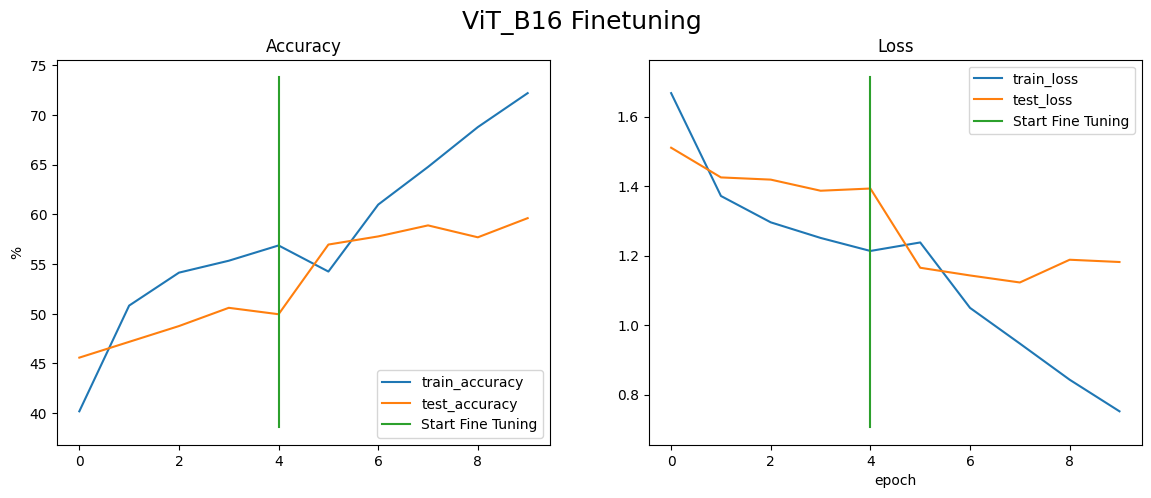

In [52]:
# 10. Plot loss curves - Compare Feature extraction vs. Fine tuning

results_ViT_20percent = pd.read_csv(PATH_results / "results_ViT_B16_20percent.csv").to_dict(orient='list')
results_ViT_FT = pd.read_csv(PATH_results / "results_ViT_B16_FT.csv").to_dict(orient='list')

compare_results(results_ViT_20percent,results_ViT_FT,
                initial_epochs=5,
                fig_name="fig_ViT_B16_FT",save_fig=True,
                suptitle="ViT_B16 Finetuning")

## <a class="anchor" id="resnet-50">V. Resnet Model</a>


### Build the model

In [53]:
model_0 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model_0

Using cache found in /home/silama3/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Print a summary using torchinfo

In [54]:
def get_model_summary(model,input_size=(1,3,FLAGS['IMAGE_SIZE'],FLAGS['IMAGE_SIZE'])):
  """print and return the model summary using torchinfo.summary()"""
  model_summary = torchinfo.summary(model,
                                    input_size=input_size,
                                    col_names=["input_size","output_size","num_params","trainable"],
                                    col_width=15)
  print(model_summary)
  return model_summary

In [55]:
summary_model_0 = get_model_summary(model_0)

Layer (type:depth-idx)                   Input Shape     Output Shape    Param #         Trainable
ResNet                                   [1, 3, 224, 224] [1, 1000]       --              True
├─Conv2d: 1-1                            [1, 3, 224, 224] [1, 64, 112, 112] 9,408           True
├─BatchNorm2d: 1-2                       [1, 64, 112, 112] [1, 64, 112, 112] 128             True
├─ReLU: 1-3                              [1, 64, 112, 112] [1, 64, 112, 112] --              --
├─MaxPool2d: 1-4                         [1, 64, 112, 112] [1, 64, 56, 56] --              --
├─Sequential: 1-5                        [1, 64, 56, 56] [1, 256, 56, 56] --              True
│    └─Bottleneck: 2-1                   [1, 64, 56, 56] [1, 256, 56, 56] --              True
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56] [1, 64, 56, 56] 4,096           True
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56] [1, 64, 56, 56] 128             True
│    │    └─ReLU: 3-3                    [1

### Create DataLoaders using custom transforms (Resize + TrivialAugmentWide)

In [56]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    """Train the model on the dataloader"""

    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
        # 1. Send data to target device
        X, y = X.to(device), y.to(device)

        # 2. Forward pass
        pred_logits = model(X)
        pred_labels = torch.argmax(torch.softmax(pred_logits, dim=1), dim=1)

        # 3. Calculate and accumulate loss
        loss = loss_fn(pred_logits, y)
        train_loss += loss.item()

        # 4. Calculate and accumulate accuracy
        acc = accuracy_fn(y,pred_labels)
        train_acc += acc

        # 5. Gradient Descent
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 6. print train loss and accuracy per batch
        if batch % FLAGS['show_results_every_X_batch'] == 0:
          print(f"batch: {batch} | train_loss: {loss.item()} | train_acc: {acc}")

    # 7. Get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

#### Create a test loop function

In [57]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    """Evaluate the model on the dataloader"""
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # 1. Send data to target device
            X, y = X.to(device), y.to(device)

            # 2. Forward pass
            test_pred_logits = model(X)
            test_pred_labels = test_pred_logits.argmax(dim=1)

            # 3. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # 4. Calculate and accumulate accuracy
            test_acc += accuracy_fn(y,test_pred_labels)

    # 5. Get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

#### Combine train and test loop functions

Let's combine the train and test loop function in one function: train_and_evaluate.

We will use CrossEntropyLoss as the loss function and Adam as the optimizer. The learning rate for the Adam optimizer is set to 0.001 by default.

### Train and evaluate model_0 (Resnet50)

In [58]:
# 1. train and evaluate the model

torch.manual_seed(42)
torch.cuda.manual_seed(42)

results_model_0 = train_and_evaluate(model=model_0,
                                     train_dataloader=train_DataLoader,
                                     test_dataloader=test_DataLoader,
                                     epochs=5)

  0%|                                                                                                                                                                                 | 0/5 [00:00<?, ?it/s]


epoch: 0
--------------------------
batch: 0 | train_loss: 9.995887756347656 | train_acc: 0.0
batch: 100 | train_loss: 2.111762523651123 | train_acc: 25.0
batch: 200 | train_loss: 1.9685659408569336 | train_acc: 31.25
batch: 300 | train_loss: 1.818007469177246 | train_acc: 34.375
batch: 400 | train_loss: 2.106544017791748 | train_acc: 15.625
batch: 500 | train_loss: 1.5624206066131592 | train_acc: 46.875
batch: 600 | train_loss: 1.3799394369125366 | train_acc: 53.125
batch: 700 | train_loss: 1.4879167079925537 | train_acc: 40.625
batch: 800 | train_loss: 1.746103286743164 | train_acc: 43.75
batch: 900 | train_loss: 1.3433711528778076 | train_acc: 50.0
batch: 1000 | train_loss: 1.8612197637557983 | train_acc: 37.5
batch: 1100 | train_loss: 1.5246708393096924 | train_acc: 43.75
batch: 1200 | train_loss: 1.588273286819458 | train_acc: 37.5
batch: 1300 | train_loss: 1.336447834968567 | train_acc: 46.875
batch: 1400 | train_loss: 1.239471435546875 | train_acc: 65.625
batch: 1500 | train_lo

 20%|█████████████████████████████████▌                                                                                                                                      | 1/5 [05:23<21:33, 323.31s/it]

Epoch: 0 | train_loss: 1.7308 | train_acc: 37.1341 | test_loss: 1.7089 | test_acc: 38.7280

epoch: 1
--------------------------
batch: 0 | train_loss: 1.7097762823104858 | train_acc: 40.625
batch: 100 | train_loss: 1.839386224746704 | train_acc: 31.25
batch: 200 | train_loss: 1.589888095855713 | train_acc: 43.75
batch: 300 | train_loss: 1.5167086124420166 | train_acc: 40.625
batch: 400 | train_loss: 1.9787161350250244 | train_acc: 25.0
batch: 500 | train_loss: 1.4564050436019897 | train_acc: 43.75
batch: 600 | train_loss: 1.6033488512039185 | train_acc: 40.625
batch: 700 | train_loss: 1.2935959100723267 | train_acc: 53.125
batch: 800 | train_loss: 1.38617742061615 | train_acc: 46.875
batch: 900 | train_loss: 1.5922492742538452 | train_acc: 46.875
batch: 1000 | train_loss: 1.741342544555664 | train_acc: 37.5
batch: 1100 | train_loss: 1.770498514175415 | train_acc: 40.625
batch: 1200 | train_loss: 1.4453881978988647 | train_acc: 40.625
batch: 1300 | train_loss: 1.5424606800079346 | train

 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 2/5 [10:46<16:10, 323.42s/it]

Epoch: 1 | train_loss: 1.5408 | train_acc: 43.5741 | test_loss: 1.7443 | test_acc: 38.3087

epoch: 2
--------------------------
batch: 0 | train_loss: 1.3982206583023071 | train_acc: 50.0
batch: 100 | train_loss: 1.2368627786636353 | train_acc: 53.125
batch: 200 | train_loss: 1.4715828895568848 | train_acc: 40.625
batch: 300 | train_loss: 1.212628722190857 | train_acc: 56.25
batch: 400 | train_loss: 1.3022994995117188 | train_acc: 50.0
batch: 500 | train_loss: 1.5520612001419067 | train_acc: 37.5
batch: 600 | train_loss: 1.6514930725097656 | train_acc: 40.625
batch: 700 | train_loss: 1.282697319984436 | train_acc: 43.75
batch: 800 | train_loss: 1.2940430641174316 | train_acc: 62.5
batch: 900 | train_loss: 1.2861440181732178 | train_acc: 53.125
batch: 1000 | train_loss: 1.2708375453948975 | train_acc: 46.875
batch: 1100 | train_loss: 1.6585572957992554 | train_acc: 37.5
batch: 1200 | train_loss: 1.3923801183700562 | train_acc: 46.875
batch: 1300 | train_loss: 1.54611074924469 | train_ac

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 3/5 [16:10<10:47, 323.60s/it]

Epoch: 2 | train_loss: 1.4664 | train_acc: 45.8953 | test_loss: 1.5583 | test_acc: 43.8099

epoch: 3
--------------------------
batch: 0 | train_loss: 1.1927708387374878 | train_acc: 65.625
batch: 100 | train_loss: 1.231213092803955 | train_acc: 56.25
batch: 200 | train_loss: 1.4065356254577637 | train_acc: 53.125
batch: 300 | train_loss: 1.89301598072052 | train_acc: 37.5
batch: 400 | train_loss: 1.3737080097198486 | train_acc: 53.125
batch: 500 | train_loss: 1.4128957986831665 | train_acc: 43.75
batch: 600 | train_loss: 1.3321363925933838 | train_acc: 46.875
batch: 700 | train_loss: 1.5780959129333496 | train_acc: 40.625
batch: 800 | train_loss: 1.2421914339065552 | train_acc: 53.125
batch: 900 | train_loss: 1.431557536125183 | train_acc: 53.125
batch: 1000 | train_loss: 1.1998250484466553 | train_acc: 46.875
batch: 1100 | train_loss: 1.3659034967422485 | train_acc: 50.0
batch: 1200 | train_loss: 1.5015286207199097 | train_acc: 53.125
batch: 1300 | train_loss: 1.3351339101791382 | tr

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 4/5 [21:34<05:23, 323.70s/it]

Epoch: 3 | train_loss: 1.4213 | train_acc: 47.6827 | test_loss: 1.5391 | test_acc: 44.2792

epoch: 4
--------------------------
batch: 0 | train_loss: 1.216611385345459 | train_acc: 65.625
batch: 100 | train_loss: 1.344995379447937 | train_acc: 59.375
batch: 200 | train_loss: 1.1277161836624146 | train_acc: 59.375
batch: 300 | train_loss: 1.2214512825012207 | train_acc: 56.25
batch: 400 | train_loss: 1.13308846950531 | train_acc: 59.375
batch: 500 | train_loss: 1.0699379444122314 | train_acc: 65.625
batch: 600 | train_loss: 1.6586852073669434 | train_acc: 31.25
batch: 700 | train_loss: 1.6503397226333618 | train_acc: 37.5
batch: 800 | train_loss: 1.3446601629257202 | train_acc: 37.5
batch: 900 | train_loss: 1.0907626152038574 | train_acc: 59.375
batch: 1000 | train_loss: 1.0561723709106445 | train_acc: 53.125
batch: 1100 | train_loss: 1.5524699687957764 | train_acc: 56.25
batch: 1200 | train_loss: 1.6886653900146484 | train_acc: 46.875
batch: 1300 | train_loss: 1.1574187278747559 | tra

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [26:57<00:00, 323.52s/it]

Epoch: 4 | train_loss: 1.3648 | train_acc: 49.6921 | test_loss: 1.4928 | test_acc: 46.9249
Total training time: 1617.589 seconds


### Save the results to CSV

In [56]:
def save_results_to_CSV(model_results,model_name,split_size,results_save_path):
  model_results_pd = pd.DataFrame(model_results)
  model_results_pd['model_name'] = model_name
  model_results_pd['data'] = split_size
  print(f"Saving results to: {results_save_path}")
  model_results_pd.to_csv(results_save_path,index=False)

In [57]:
save_results_to_CSV(model_results=results_model_0,
                    model_name = "Resnet50",
                    split_size = 1,
                    results_save_path = PATH_results / "results_Resnet50.csv")

Saving results to: kaggle/working/results/results_Resnet50.csv


### Plot loss curves

In [60]:
def plot_loss_curves(results,graph_name="fig",save_graph=False,
                     PATH_results=PATH_results,suptitle=""):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g. {"train_loss": [...], "train_acc": [...],...}
        graph_name (str): the name of the graph
        save_graph (boolean): if True, the graph will be saved
        PATH_results: the path where the graph will be stored
        suptitle (str): add a suptitle, default None
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    if suptitle!="":
        plt.suptitle(suptitle, fontsize=18)

    # Save the figure
    if save_graph:
        graph_name = graph_name+".jpg"
        plt.savefig(PATH_results / graph_name)

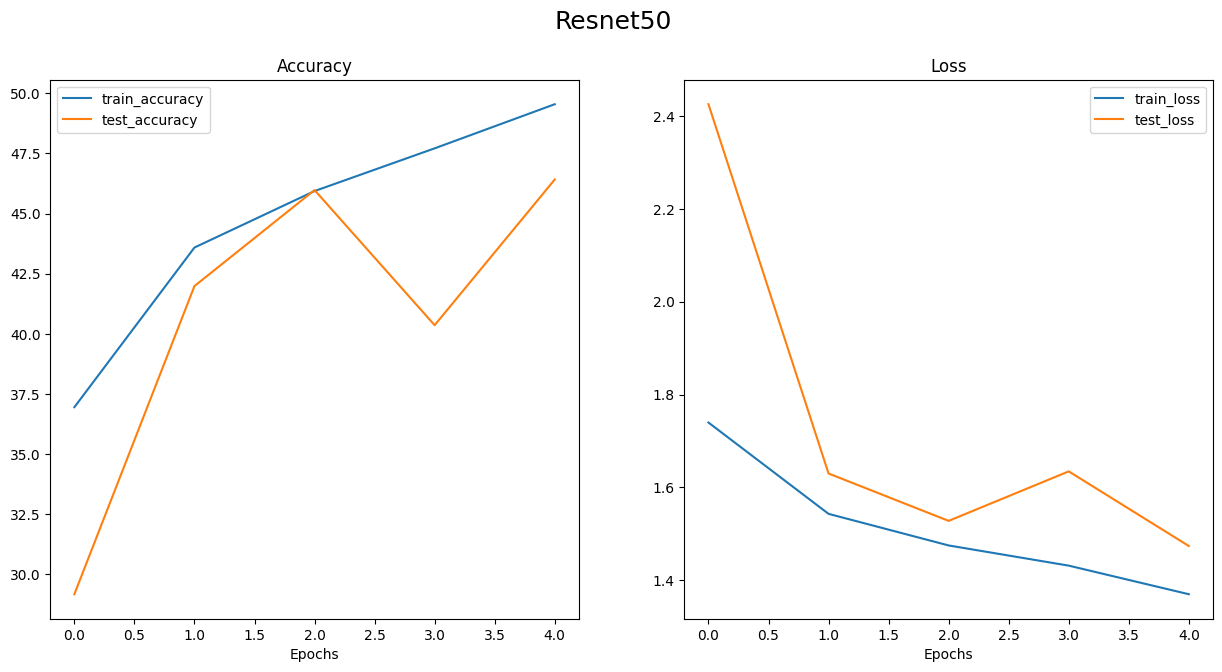

In [67]:
results_model_0 = pd.read_csv(PATH_results / "results_Resnet50.csv")
plot_loss_curves(results_model_0,
                 graph_name="fig_Resnet50",save_graph=True,
                 suptitle="Resnet50")

### Save the model

We will save model's `state_dict()` using `torch.save()`.

In [62]:
def save_model(model,MODEL_SAVE_PATH):
  """Save the model state dict: only saves the learned parameters"""

  print(f"Saving model to: {MODEL_SAVE_PATH}")
  torch.save(obj=model.state_dict(),
             f=MODEL_SAVE_PATH)

In [63]:
save_model(model = model_0,
           MODEL_SAVE_PATH = PATH_models / "Resnet50.pth"
           )

Saving model to: kaggle/working/models/Resnet50.pth


### Make predictions and calculate average prediction time

Let's create a function called `pred_and_timing()` to iterate over test images and find the average prediction time.

In [64]:
# Get all test data paths
test_dir = image_path / "test"
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Get 200 random images
random_image_paths = random.sample(test_data_paths,200)
print(f"[INFO] Random selection of 200 images from {test_dir}")

[INFO] Random selection of 200 images from kaggle/working/artbench-10-imagefolder-split/test


In [40]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

def pred_and_timing(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
    print("\nMake predictions and calculate average prediction time...")

    pred_list = [] # list to store prediction dictionaires

    for path in tqdm(paths):

        pred_dict = {} # dict to store prediction information (path, class_name, pred_prob, pred_class and time_for_pred)

        # Set path and class_name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        start_time = timer() # 5. Start the prediction timer

        # Open image path
        img = Image.open(path)

        # Transform the image and add batch dimension
        transformed_image = transform(img).unsqueeze(0).to(device)

        # Prepare model for inference
        model.to(device)
        model.eval()

        # Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # prediction logits
            pred_prob = torch.softmax(pred_logit, dim=1) # prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # prediction labels
            pred_class = class_names[pred_label.cpu()]

            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            # Calculate prediction time
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # Was the prediction right?
        pred_dict["correct"] = class_name == pred_class

        # Add the dict to the list of preds
        pred_list.append(pred_dict)

        # Convert to dataframe
        pred_df = pd.DataFrame(pred_list)

        # Calculate average prediction time
        avg_prediction_time = round(pred_df.time_for_pred.mean(), 4)

    return pred_list,pred_df,avg_prediction_time

> As we will be deploying our application on HuggingFace Spaces and using free CPUs, we will check the average prediction time of our model using the CPU device.

In [66]:
# Make predictions and calculate avg prediction time using Resnet50
Resnet50_test_pred_dicts,Resnet50_test_pred_df,Resnet50_avg_prediction_time =\
pred_and_timing(paths=random_image_paths,
                model=model_0,
                transform=data_transform,
                class_names=class_names,
                device="cpu") # make predictions on CPU

print("Resnet50_avg_prediction_time:",Resnet50_avg_prediction_time)
Resnet50_test_pred_df[:5]


Make predictions and calculate average prediction time...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 27.03it/s]

Resnet50_avg_prediction_time: 0.0354


,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,kaggle/working/artbench-10-imagefolder-split/t...,romanticism,0.3120,realism,0.1593,False
1,kaggle/working/artbench-10-imagefolder-split/t...,renaissance,0.2035,romanticism,0.0377,False
2,kaggle/working/artbench-10-imagefolder-split/t...,ukiyo_e,0.9846,ukiyo_e,0.0370,True
3,kaggle/working/artbench-10-imagefolder-split/t...,expressionism,0.3288,expressionism,0.0366,True
4,kaggle/working/artbench-10-imagefolder-split/t...,baroque,0.5972,baroque,0.0382,True
